<a href="https://www.kaggle.com/saraswatitiwari/tps-january-2022?scriptVersionId=84555953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#### What are you trying to do in this notebook?
For this challenge, we will be predicting a full year worth of sales for three items at two stores located in three different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. The dataset is small enough to allow us to try numerous different modeling approaches.

#### Why are you trying it?
There are two (fictitious) independent store chains selling Kaggle merchandise that want to become the official outlet for all things Kaggle. we want to figure out which of the store chains(KaggleMart or KaggleRama) would have the best sales going forward.

Files

- train.csv - the training set, which includes the sales data for each date-country-store-item combination.
- test.csv - the test set; your task is to predict the corresponding item sales for each date-country-store-item combination. Note the Public leaderboard is scored on the first quarter of the test year, and the Private on the remaining.
- sample_submission.csv - a sample submission file in the correct format.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv
/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools
import gc
import math
import matplotlib.pyplot as plt
import dateutil.easter as easter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor

In [3]:
original_train_df = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
original_test_df = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')
gdp_df = pd.read_csv('../input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')

gdp_df.set_index('year', inplace=True)

# The dates are read as strings and must be converted
for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True, drop=False)
original_train_df.head(2)

,row_id,date,country,store,product,num_sold
date,,,,,,
2015-01-01,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520


In [4]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

#print(smape_loss(tf.constant([1, 2]), tf.constant([3, 4]))) # should print [100, 66.6667]

In [5]:
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]
        
    new_df = pd.DataFrame({#'year': df.date.dt.year, # This feature makes it possible to fit an annual growth rate
                           'dayofyear': df.date.dt.dayofyear,
                           'gdp': df.apply(get_gdp, axis=1),
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                          })

    # Growth is country-specific
    #for country in ['Finland', 'Norway', 'Sweden']:
        #new_df[f"{country}_year"] = (df.country == country) * (df.date.dt.year - 2016)
        #new_df[f"{country}_peak_year"] = (df.country == country) * (new_df.dec29 | new_df.dec30 | new_df.easter_week) * (df.date.dt.year - 2016)
        
    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Sticker']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 20):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'sticker_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Sticker']
        new_df[f'sticker_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Sticker']

    return new_df

train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)
#test_df.year = 2018 # no growth patch, see https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298318

features = test_df.columns

for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float32)
print(list(features))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

['dayofyear', 'gdp', 'wd4', 'wd56', 'Finland', 'Norway', 'KaggleRama', 'Kaggle Mug', 'Kaggle Sticker', 'sin1', 'cos1', 'mug_sin1', 'mug_cos1', 'sticker_sin1', 'sticker_cos1', 'sin2', 'cos2', 'mug_sin2', 'mug_cos2', 'sticker_sin2', 'sticker_cos2', 'sin3', 'cos3', 'mug_sin3', 'mug_cos3', 'sticker_sin3', 'sticker_cos3', 'sin4', 'cos4', 'mug_sin4', 'mug_cos4', 'sticker_sin4', 'sticker_cos4', 'sin5', 'cos5', 'mug_sin5', 'mug_cos5', 'sticker_sin5', 'sticker_cos5', 'sin6', 'cos6', 'mug_sin6', 'mug_cos6', 'sticker_sin6', 'sticker_cos6', 'sin7', 'cos7', 'mug_sin7', 'mug_cos7', 'sticker_sin7', 'sticker_cos7', 'sin8', 'cos8', 'mug_sin8', 'mug_cos8', 'sticker_sin8', 'sticker_cos8', 'sin9', 'cos9', 'mug_sin9', 'mug_cos9', 'sticker_sin9', 'sticker_cos9', 'sin10', 'cos10', 'mug_sin10', 'mug_cos10', 'sticker_sin10', 'sticker_cos10', 'sin11', 'cos11', 'mug_sin11', 'mug_cos11', 'sticker_sin11', 'sticker_cos11', 'sin12', 'cos12', 'mug_sin12', 'mug_cos12', 'sticker_sin12', 'sticker_cos12', 'sin13', 'cos13

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

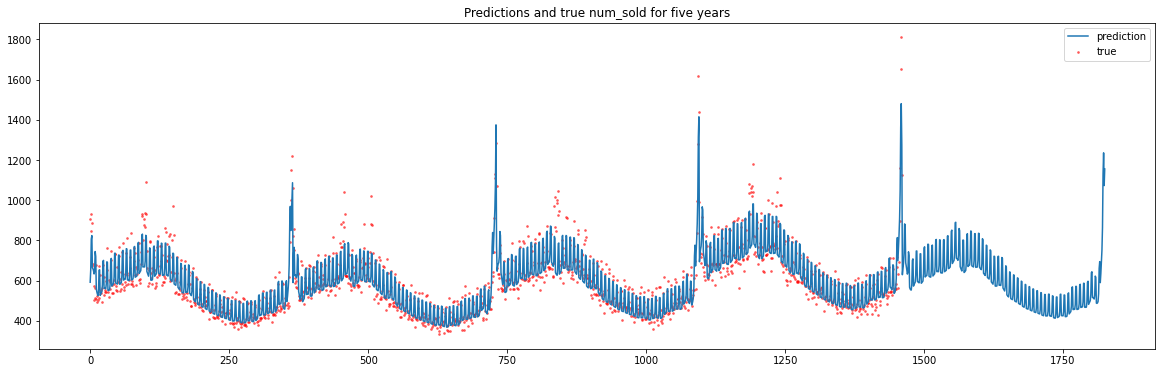

In [6]:
def fit_model(X_tr, X_va=None, outliers=False):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression() # 5.80558
    model = HuberRegressor(epsilon=1.20, max_iter=500) # 5.80143 (epsilon=1.20) *****************
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        print(np.mean(smape_loss(y_va, y_va_pred)))
        
        # Plot y_true vs. y_pred
        plt.figure(figsize=(10, 10))
        plt.scatter(y_va, y_va_pred, s=1, color='r')
        #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
        plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
        plt.gca().set_aspect('equal')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.title('OOF Predictions')
        plt.show()
        
    return preproc, model

preproc, model = fit_model(train_df)

# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
def plot_five_years_combination(engineer, country='Norway', store='KaggleMart', product='Kaggle Hat'):
    demo_df = pd.DataFrame({'row_id': 0,
                            'date': pd.date_range('2015-01-01', '2019-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})
    demo_df.set_index('date', inplace=True, drop=False)
    demo_df = engineer(demo_df)
    demo_df['num_sold'] = np.exp(model.predict(preproc.transform(demo_df[features])))
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(demo_df)), demo_df.num_sold, label='prediction')
    train_subset = train_df[(original_train_df.country == country) & (original_train_df.store == store) & (original_train_df['product'] == product)]
    plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Predictions and true num_sold for five years')
    plt.show()

plot_five_years_combination(engineer)

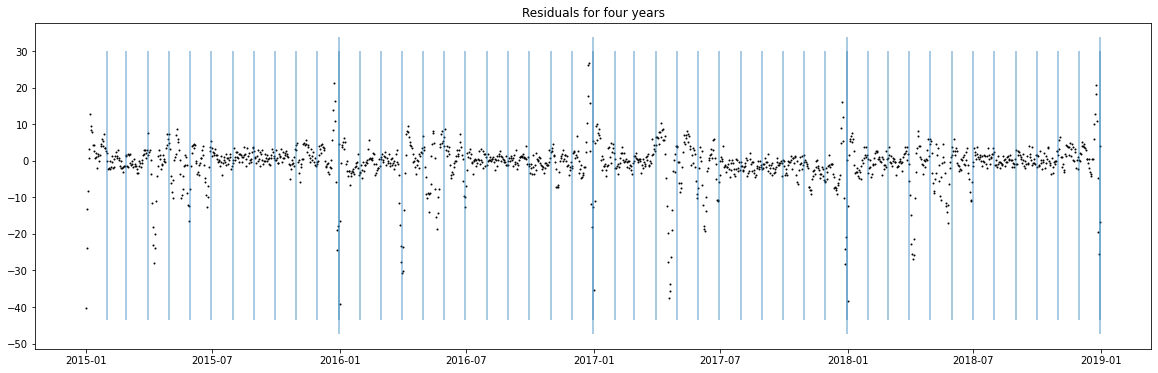

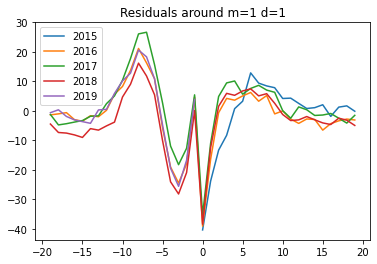

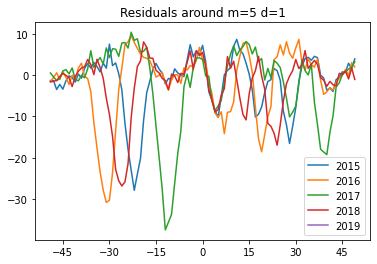

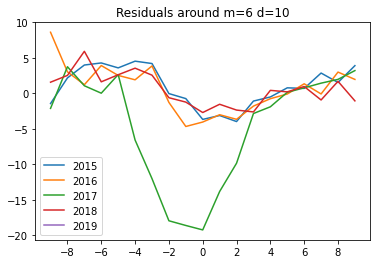

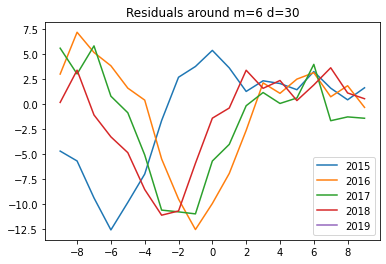

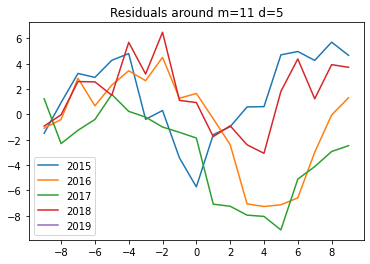

In [7]:
train_df['pred'] = np.exp(model.predict(preproc.transform(train_df[features])))
by_date = train_df.groupby(level='date')
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all residuals (four-year range, sum of all products)
def plot_all_residuals(residuals):
    plt.figure(figsize=(20,6))
    plt.scatter(residuals.index,
                residuals,
                s=1, color='k')
    plt.vlines(pd.date_range('2015-01-01', '2019-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    plt.vlines(pd.date_range('2015-01-01', '2019-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    plt.title('Residuals for four years')
    plt.show()
    
plot_all_residuals(residuals)

# Plot residuals for interesting intervals
def plot_around(residuals, m, d, w):
    """Plot residuals in an interval of with 2*w around month=m and day=d"""
    plt.figure()
    plt.title(f"Residuals around m={m} d={d}")
    for y in np.arange(2015, 2020):
        d0 = pd.Timestamp(date(y, m, d))
        residual_range = residuals[(residuals.index > d0 - timedelta(w)) & 
                                   (residuals.index < d0 + timedelta(w))]
        plt.plot([(r - d0).days for r in residual_range.index], residual_range, label=str(y))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    plt.legend()
    plt.show()

plot_around(residuals, 1, 1, 20) # end of year peak
plot_around(residuals, 5, 1, 50) # three moveable peaks depending on Easter
#plot_around(residuals, 5, 21, 10) # zoom-in
#plot_around(residuals, 5, 31, 15) # zoom-in
plot_around(residuals, 6, 10, 10) # first half of June (with overlay of Pentecost in 2017)
plot_around(residuals, 6, 30, 10) # moveable peak end of June
plot_around(residuals, 11, 5, 10) # moveable peak beginning of November

In [8]:
# Feature engineering
def engineer_more(df):
    """Return a new dataframe with more engineered features"""
    new_df = engineer(df)

    # End of year
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)})],
                       axis=1)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) 
                                      for d in range(1, 13)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10)) + list(range(17, 25))})],
                       axis=1)
    
    # June
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) 
                                      for d in list(range(6, 14))})],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D"))
                                      for d in list(range(-5, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D"))
                                      for d in list(range(0, 10))})],
                       axis=1)
    
    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(0, 9)) + list(range(50, 60)) + list(range(40, 46))})],
                       axis=1)
    
    # Growth is country-specific
    #for country in ['Finland', 'Norway', 'Sweden']:
    #    new_df[f"{country}_year"] = (df.country == country) * (df.date.dt.year - 2016)
    #    new_df[f"{country}_peak_year"] = (df.country == country) * (new_df.dec29 | new_df.dec30 | new_df.easter_week) * (df.date.dt.year - 2016)
        
    return new_df.astype(np.float32)

train_df = engineer_more(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer_more(original_test_df)
test_df.year = 2018 # no growth patch, see https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298318

features = test_df.columns
print(list(features))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

['dayofyear', 'gdp', 'wd4', 'wd56', 'Finland', 'Norway', 'KaggleRama', 'Kaggle Mug', 'Kaggle Sticker', 'sin1', 'cos1', 'mug_sin1', 'mug_cos1', 'sticker_sin1', 'sticker_cos1', 'sin2', 'cos2', 'mug_sin2', 'mug_cos2', 'sticker_sin2', 'sticker_cos2', 'sin3', 'cos3', 'mug_sin3', 'mug_cos3', 'sticker_sin3', 'sticker_cos3', 'sin4', 'cos4', 'mug_sin4', 'mug_cos4', 'sticker_sin4', 'sticker_cos4', 'sin5', 'cos5', 'mug_sin5', 'mug_cos5', 'sticker_sin5', 'sticker_cos5', 'sin6', 'cos6', 'mug_sin6', 'mug_cos6', 'sticker_sin6', 'sticker_cos6', 'sin7', 'cos7', 'mug_sin7', 'mug_cos7', 'sticker_sin7', 'sticker_cos7', 'sin8', 'cos8', 'mug_sin8', 'mug_cos8', 'sticker_sin8', 'sticker_cos8', 'sin9', 'cos9', 'mug_sin9', 'mug_cos9', 'sticker_sin9', 'sticker_cos9', 'sin10', 'cos10', 'mug_sin10', 'mug_cos10', 'sticker_sin10', 'sticker_cos10', 'sin11', 'cos11', 'mug_sin11', 'mug_cos11', 'sticker_sin11', 'sticker_cos11', 'sin12', 'cos12', 'mug_sin12', 'mug_cos12', 'sticker_sin12', 'sticker_cos12', 'sin13', 'cos13

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

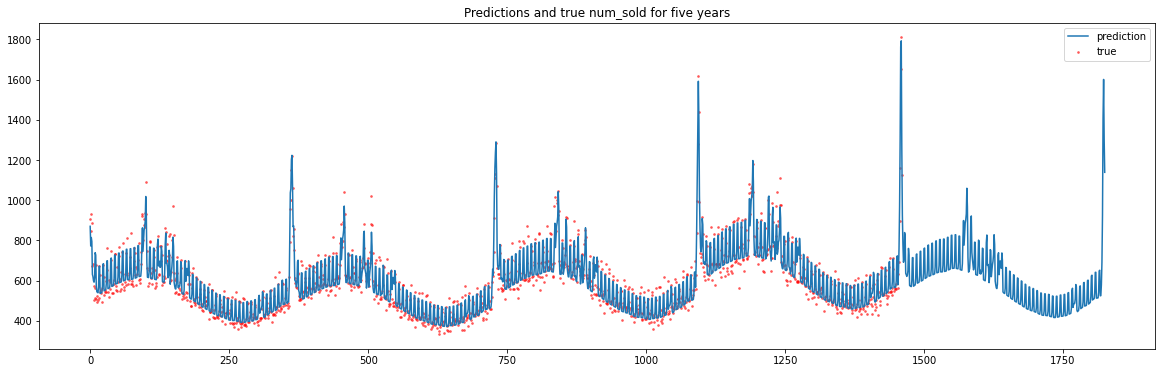

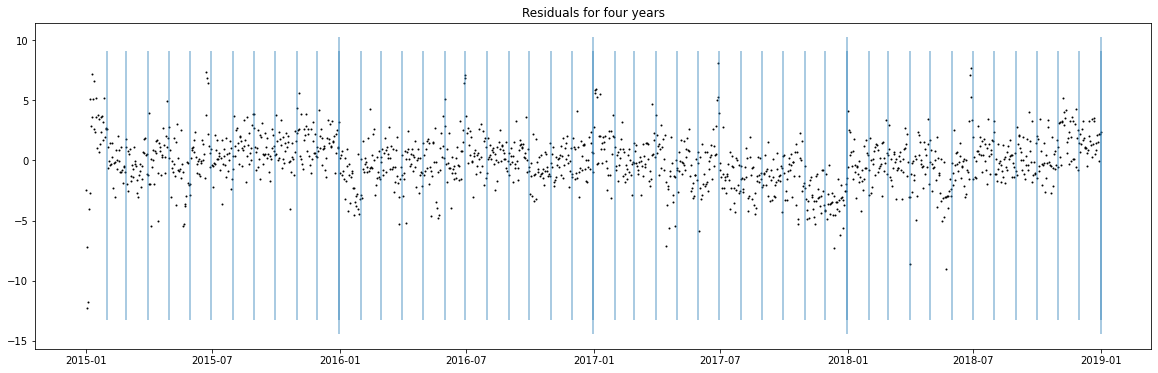

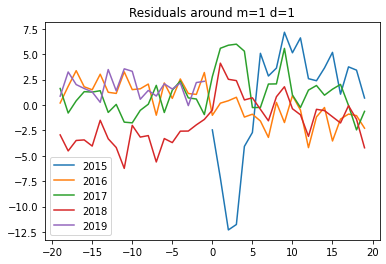

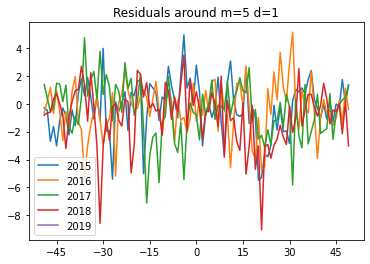

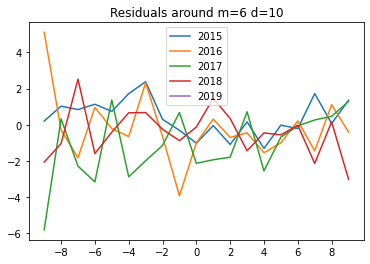

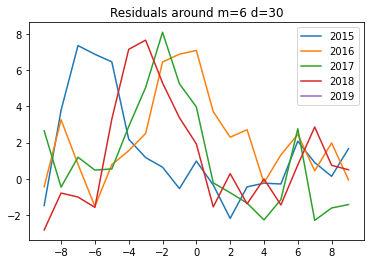

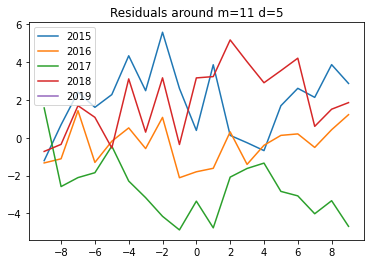

In [9]:
preproc, model = fit_model(train_df)
train_df['pred'] = np.exp(model.predict(preproc.transform(train_df[features])))
by_date = train_df.groupby(level='date')
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
plot_five_years_combination(engineer_more)

# Plot all residuals (four-year range, sum of all products)
plot_all_residuals(residuals)

# Plot residuals for interesting intervals
plot_around(residuals, 1, 1, 20) # end of year peak
plot_around(residuals, 5, 1, 50) # three moveable peaks depending on Easter
#plot_around(residuals, 5, 21, 10) # zoom-in
#plot_around(residuals, 5, 31, 15) # zoom-in
plot_around(residuals, 6, 10, 10) # first half of June (with overlay of Pentecost in 2017)
plot_around(residuals, 6, 30, 10) # moveable peak end of June
plot_around(residuals, 11, 5, 10) # moveable peak beginning of November

Fold 0.0
Fold 0.0 | 00:06 | SMAPE: 5.59961   (before correction: 5.59961)
5.59960970525895


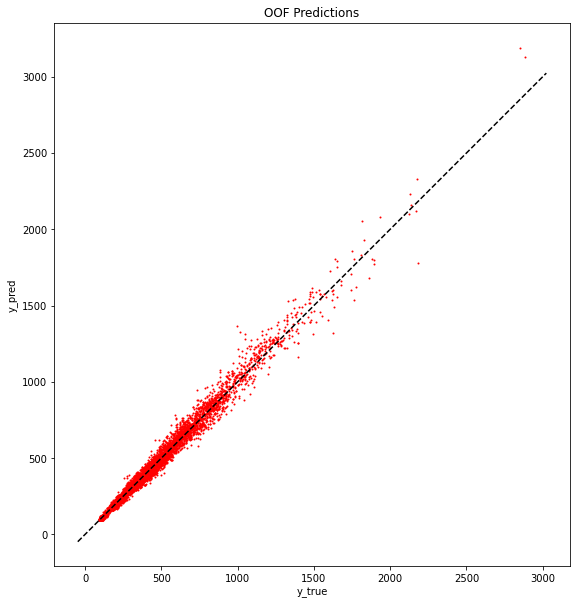

In [10]:
#%%time
RUNS = 1 # should be 1. increase the number of runs only if you want see how the result depends on the random seed
OUTLIERS = True
TRAIN_VAL_CUT = datetime(2018, 1, 1)
LOSS_CORRECTION = 1 # correction factor between Huber loss and SMAPE: 1.035 ( for linear regression with MSE use 1.038)

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
for run in range(RUNS):
    fold = 0
    train_idx = np.arange(len(train_df))[train_df.date < TRAIN_VAL_CUT]
    val_idx = np.arange(len(train_df))[train_df.date > TRAIN_VAL_CUT]
    print(f"Fold {run}.{fold}")
    X_tr = train_df.iloc[train_idx]
    X_va = train_df.iloc[val_idx]
    
    preproc, model = fit_model(X_tr, X_va)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

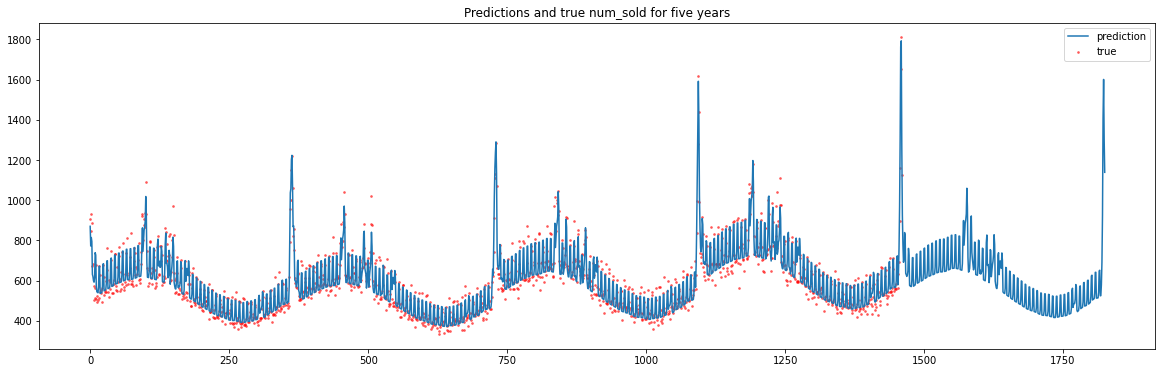

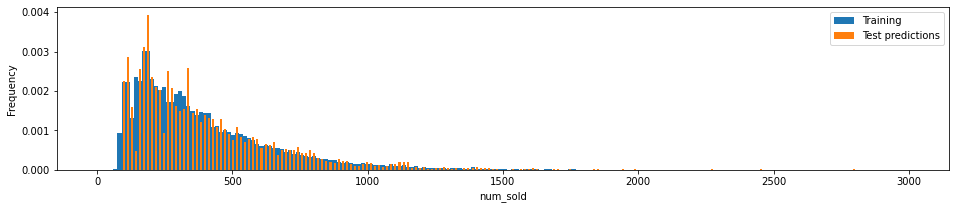

In [11]:
# Fit the model on the complete training data
train_idx = np.arange(len(train_df))
X_tr = train_df.iloc[train_idx]
preproc, model = fit_model(X_tr, None)

plot_five_years_combination(engineer_more) # Quick check for debugging

# Inference for test
test_pred_list = []
test_pred_list.append(np.exp(model.predict(preproc.transform(test_df[features]))) * LOSS_CORRECTION)

if len(test_pred_list) > 0:
    # Create the submission file
    sub = original_test_df[['row_id']].copy()
    sub['num_sold'] = sum(test_pred_list) / len(test_pred_list)
    sub.to_csv('submission.csv', index=False)

    # Plot the distribution of the test predictions
    plt.figure(figsize=(16,3))
    plt.hist(train_df['num_sold'], bins=np.linspace(0, 3000, 201),
             density=True, label='Training')
    plt.hist(sub['num_sold'], bins=np.linspace(0, 3000, 201),
             density=True, rwidth=0.5, label='Test predictions')
    plt.xlabel('num_sold')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [12]:
sub

,row_id,num_sold
date,,
2019-01-01,26298,373.156219
2019-01-01,26299,577.556724
2019-01-01,26300,166.348735
2019-01-01,26301,650.888681
2019-01-01,26302,1007.420258
...,...,...
2019-12-31,32863,793.414381
2019-12-31,32864,229.553181
2019-12-31,32865,898.447965


#### Did it work?
The notebook goes together with the EDA notebook, which visualizes the various seasonal effects and the differences in growth rate. Scikit-learn doesn't offer SMAPE as a loss function. As a workaround, I'm training for Huber loss with a transformed target, apply a correction factor, and we'll see how far we'll get.

The transformed target for the regression is the log of the sales numbers.

#### What did you not understand about this process?
Well, everything provides in the competition data page. I've no problem while working on it. If you guys don't understand the thing that I'll do in this notebook then please comment on this notebook.

#### What else do you think you can try as part of this approach? 
Look at a notebook which presents feature engineering (based on the insights of this EDA) and a linear model which makes use of the features.